<a href="https://colab.research.google.com/github/Jack-Hayes/datascience/blob/main/tsa_rnn_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

In [ ]:
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
# here we need functions for building the Neural Network
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [ ]:
data = pd.read_csv('drive/MyDrive/Data Sets/airline-passengers.csv',usecols=[1], engine='python')

In [ ]:
data

,Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


In [ ]:
dataset = data.values
dataset = dataset.astype('float32')

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
dataset.shape

(144, 1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [ ]:
test

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
np.concatenate((trainX,trainY.reshape(-1,1)),axis=1)

In [ ]:
# reshape input to be [samples, time steps x features]
trainX = np.reshape(trainX, (trainX.shape[0], 1,trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
trainX[0].shape

(1, 2)

In [ ]:
testX.shape

(46, 1, 1)

In [ ]:
a = np.array([1,2,3,4,5,6,7,8,9,10,11,12])

In [ ]:
np.reshape(a,(3,4))

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mse(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mse(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 24.84 RMSE
Test Score: 46.14 RMSE


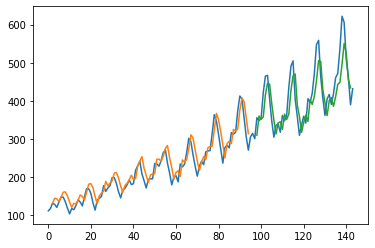

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Multivariate LSTM Example

In [ ]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('drive/MyDrive/Data Sets/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


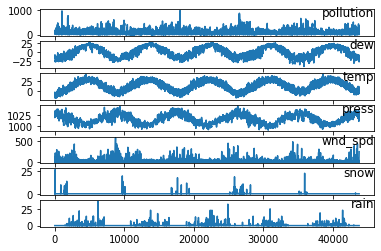

In [ ]:
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [ ]:
reframed['var8(t)'].describe()

count    43798.000000
mean         0.005418
std          0.039345
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: var8(t), dtype: float64

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 16) (8760,) (35038, 1, 16) (35038,)


Epoch 1/100
122/122 - 4s - loss: 0.0173 - val_loss: 0.0160 - 4s/epoch - 33ms/step
Epoch 2/100
122/122 - 1s - loss: 0.0096 - val_loss: 0.0066 - 942ms/epoch - 8ms/step
Epoch 3/100
122/122 - 1s - loss: 0.0089 - val_loss: 0.0078 - 923ms/epoch - 8ms/step
Epoch 4/100
122/122 - 1s - loss: 0.0089 - val_loss: 0.0066 - 937ms/epoch - 8ms/step
Epoch 5/100
122/122 - 1s - loss: 0.0089 - val_loss: 0.0073 - 985ms/epoch - 8ms/step
Epoch 6/100
122/122 - 1s - loss: 0.0083 - val_loss: 0.0078 - 1s/epoch - 8ms/step
Epoch 7/100
122/122 - 1s - loss: 0.0085 - val_loss: 0.0074 - 986ms/epoch - 8ms/step
Epoch 8/100
122/122 - 1s - loss: 0.0082 - val_loss: 0.0083 - 967ms/epoch - 8ms/step
Epoch 9/100
122/122 - 1s - loss: 0.0083 - val_loss: 0.0066 - 919ms/epoch - 8ms/step
Epoch 10/100
122/122 - 1s - loss: 0.0077 - val_loss: 0.0059 - 918ms/epoch - 8ms/step
Epoch 11/100
122/122 - 1s - loss: 0.0077 - val_loss: 0.0065 - 944ms/epoch - 8ms/step
Epoch 12/100
122/122 - 1s - loss: 0.0079 - val_loss: 0.0074 - 906ms/epoch - 7ms

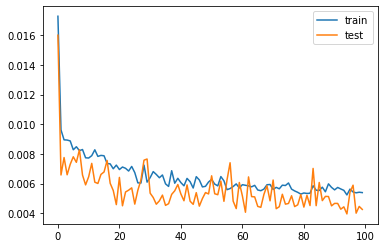

In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(1, train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

---
## JPX Stock Data

In [ ]:
stock_prices = pd.read_csv('drive/MyDrive/Kaggle/stock_prices.csv')
supplemental_stock_prices = pd.read_csv('drive/MyDrive/Kaggle/supplemental_stock_prices.csv')

In [ ]:
stock_prices.tail(5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098
2332530,20211203_9997,2021-12-03,9997,690.0,711.0,686.0,696.0,381100,1.0,NaN,False,0.018414


In [ ]:
supplemental_stock_prices.head(5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False,-0.009963
3,20211206_1375,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,NaN,False,-0.015032
4,20211206_1376,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False,0.002867


In [ ]:
total_stocks = pd.concat([stock_prices,supplemental_stock_prices],ignore_index=True)

In [ ]:
total_stocks['AdjClose'] = total_stocks['Close']*total_stocks['AdjustmentFactor']

In [ ]:
trading_dates = np.array(sorted(total_stocks['Date'].unique()))
stock_ids = np.array(sorted(total_stocks['SecuritiesCode'].unique()))

In [ ]:
map = pd.DataFrame(np.nan, index=stock_ids, columns=trading_dates)

In [ ]:
def create_factor(item, map=map):
  output_mat = pd.pivot_table(total_stocks,
                              values=item,
                              index='SecuritiesCode', columns='Date')
  output_factor = map.copy()
  output_factor.loc[output_mat.index, output_mat.columns] = output_mat.values
  return output_factor  

In [ ]:
close_factor = create_factor('AdjClose')

In [ ]:
close_factor

,2017-01-04,2017-01-05,2017-01-06,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-16,2017-01-17,2017-01-18,...,2022-05-16,2022-05-17,2022-05-18,2022-05-19,2022-05-20,2022-05-23,2022-05-24,2022-05-25,2022-05-26,2022-05-27
1301,2742.0,2738.0,2740.0,2748.0,2745.0,2731.0,2722.0,2704.0,2686.0,2694.0,...,3190.0,3280.0,3290.0,3235.0,3300.0,3325.0,3320.0,3320.0,3320.0,3310.0
1332,571.0,568.0,575.0,562.0,553.0,544.0,553.0,538.0,520.0,537.0,...,537.0,542.0,537.0,535.0,527.0,535.0,525.0,521.0,525.0,521.0
1333,3210.0,3250.0,3270.0,3235.0,3185.0,3180.0,3230.0,3240.0,3170.0,3235.0,...,2444.0,2449.0,2419.0,2372.0,2344.0,2370.0,2327.0,2217.0,2224.0,2223.0
1375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,931.0,910.0,896.0,878.0,865.0,864.0,843.0,827.0,818.0,821.0
1376,1550.0,1538.0,1555.0,1563.0,1563.0,1521.0,1538.0,1524.0,1512.0,1491.0,...,1829.0,1795.0,1815.0,1829.0,1813.0,1844.0,1812.0,1755.0,1735.0,1721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,1223.0,1266.0,1238.0,1215.0,1200.0,1177.0,1170.0,1146.0,1131.0,1126.0,...,529.0,525.0,530.0,527.0,531.0,545.0,533.0,535.0,549.0,577.0
9991,1129.0,1127.0,1127.0,1146.0,1152.0,1147.0,1150.0,1129.0,1104.0,1105.0,...,792.0,788.0,789.0,788.0,796.0,797.0,800.0,811.0,812.0,819.0
9993,1773.0,1795.0,1822.0,1869.0,1838.0,1832.0,1832.0,1810.0,1826.0,1819.0,...,1513.0,1516.0,1518.0,1502.0,1513.0,1543.0,1518.0,1526.0,1500.0,1513.0
9994,1754.0,1767.0,1765.0,1750.0,1750.0,1723.0,1736.0,1716.0,1701.0,1709.0,...,2458.0,2450.0,2442.0,2447.0,2441.0,2461.0,2441.0,2457.0,2421.0,2483.0


In [ ]:

close_factor = close_factor.transpose()

In [ ]:
close_factor

,1301,1332,1333,1375,1376,1377,1379,1381,1407,1413,...,9982,9983,9984,9987,9989,9990,9991,9993,9994,9997
2017-01-04,2742.0,571.0,3210.0,NaN,1550.0,3330.0,2143.0,1960.0,866.0,NaN,...,471.0,43290.0,7995.0,3910.0,8140.0,1223.0,1129.0,1773.0,1754.0,778.0
2017-01-05,2738.0,568.0,3250.0,NaN,1538.0,3305.0,2128.0,1930.0,885.0,NaN,...,465.0,42590.0,8153.0,3905.0,8160.0,1266.0,1127.0,1795.0,1767.0,802.0
2017-01-06,2740.0,575.0,3270.0,NaN,1555.0,3315.0,2139.0,1912.0,882.0,NaN,...,473.0,39720.0,8363.0,3910.0,8400.0,1238.0,1127.0,1822.0,1765.0,808.0
2017-01-10,2748.0,562.0,3235.0,NaN,1563.0,3330.0,2120.0,1950.0,874.0,NaN,...,471.0,38690.0,8423.0,3855.0,8490.0,1215.0,1146.0,1869.0,1750.0,804.0
2017-01-11,2745.0,553.0,3185.0,NaN,1563.0,3220.0,2109.0,1935.0,857.0,NaN,...,471.0,38560.0,8495.0,3885.0,8590.0,1200.0,1152.0,1838.0,1750.0,799.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,3325.0,535.0,2370.0,864.0,1844.0,4430.0,1932.0,3310.0,4840.0,NaN,...,1076.0,60450.0,5276.0,3445.0,2754.0,545.0,797.0,1543.0,2461.0,664.0
2022-05-24,3320.0,525.0,2327.0,843.0,1812.0,4420.0,1915.0,3310.0,4800.0,NaN,...,1022.0,59860.0,5191.0,3440.0,2745.0,533.0,800.0,1518.0,2441.0,653.0
2022-05-25,3320.0,521.0,2217.0,827.0,1755.0,4370.0,1905.0,3335.0,4570.0,NaN,...,1005.0,59580.0,5102.0,3470.0,2756.0,535.0,811.0,1526.0,2457.0,644.0
2022-05-26,3320.0,525.0,2224.0,818.0,1735.0,4240.0,1911.0,3345.0,4240.0,NaN,...,1034.0,59820.0,5164.0,3460.0,2781.0,549.0,812.0,1500.0,2421.0,648.0


In [ ]:
mms = MinMaxScaler(feature_range=(0,100))

In [ ]:
cf = mms.fit_transform(close_factor)

In [ ]:
close_factor.columns

Int64Index([1301, 1332, 1333, 1375, 1376, 1377, 1379, 1381, 1407, 1413,
            ...
            9982, 9983, 9984, 9987, 9989, 9990, 9991, 9993, 9994, 9997],
           dtype='int64', length=2000)

In [ ]:
cf_df = pd.DataFrame(cf,columns=close_factor.columns)

In [ ]:
train_data = cf_df.iloc[:900]
test_data = cf_df.iloc[900:].reset_index()

In [ ]:
test_data

,index,1301,1332,1333,1375,1376,1377,1379,1381,1407,...,9982,9983,9984,9987,9989,9990,9991,9993,9994,9997
0,900,20.177487,13.839286,20.144983,NaN,57.097458,54.729388,80.585516,25.518018,34.684167,...,65.207044,45.782527,33.516365,26.826196,20.297197,6.607495,31.600547,77.175464,27.124563,45.780969
1,901,19.897244,16.294643,21.404044,NaN,59.957627,56.246839,83.204931,27.027027,34.224774,...,63.493574,46.737901,34.162360,27.959698,21.141506,8.382643,31.326949,79.172611,27.124563,46.409336
2,902,20.411023,17.410714,22.739412,NaN,63.559322,61.052099,85.208012,27.027027,34.864643,...,62.303665,45.367693,39.814815,30.226700,22.154677,7.692308,32.558140,78.744650,27.512612,48.025135
3,903,20.457730,14.955357,21.861885,NaN,63.559322,56.752656,85.978428,26.644144,37.538966,...,62.208472,45.141420,40.051680,28.085642,20.466059,7.790927,33.652531,78.459344,27.435002,49.640934
4,904,21.391873,13.392857,22.014498,NaN,67.478814,60.799191,90.909091,26.734234,36.111567,...,64.493099,44.638592,43.249354,27.078086,21.985816,9.072978,34.062927,80.741797,27.435002,51.256732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,1312,48.388603,29.910714,18.351774,3.466466,100.000000,99.241275,43.913713,34.009009,68.826907,...,30.604474,38.277813,27.874677,10.705290,1.452212,7.100592,14.227086,45.506419,35.428793,23.967684
413,1313,48.155068,27.678571,16.711179,1.883949,96.610169,98.735458,41.294299,34.009009,68.170632,...,28.034269,37.536141,26.959518,10.579345,1.300236,5.917160,14.637483,41.940086,34.652697,22.980251
414,1314,48.155068,26.785714,12.514308,0.678222,90.572034,96.206373,39.753467,34.572072,64.397047,...,27.225131,37.184161,26.001292,11.335013,1.485984,6.114398,16.142271,43.081312,35.273574,22.172352
415,1315,48.155068,27.678571,12.781381,0.000000,88.453390,89.630754,40.677966,34.797297,58.982773,...,28.605426,37.485858,26.668820,11.083123,1.908139,7.495069,16.279070,39.372325,33.876601,22.531418


In [ ]:
train_data

,1301,1332,1333,1375,1376,1377,1379,1381,1407,1413,...,9982,9983,9984,9987,9989,9990,9991,9993,9994,9997
0,21.158337,37.946429,50.400610,NaN,68.855932,43.601416,76.425270,3.603604,3.625923,NaN,...,1.808663,16.706474,57.149009,22.418136,92.401216,73.964497,59.644323,78.316690,7.993791,34.201077
1,20.971509,37.276786,51.926746,NaN,67.584746,42.336874,74.114022,2.927928,3.937654,NaN,...,1.523084,15.826524,58.850129,22.292191,92.738940,78.205128,59.370725,81.455064,8.498254,36.355476
2,21.064923,38.839286,52.689813,NaN,69.385593,42.842691,75.808937,2.522523,3.888433,NaN,...,1.903855,12.218730,61.111111,22.418136,96.791624,75.443787,59.370725,85.306705,8.420644,36.894075
3,21.438580,35.937500,51.354445,NaN,70.233051,43.601416,72.881356,3.378378,3.757178,NaN,...,1.808663,10.923947,61.757106,21.032746,98.311381,73.175542,61.969904,92.011412,7.838572,36.535009
4,21.298459,33.928571,49.446776,NaN,70.233051,38.037430,71.186441,3.040541,3.478261,NaN,...,1.808663,10.760528,62.532300,21.788413,100.000000,71.696252,62.790698,87.589158,7.838572,36.086176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,18.402616,13.392857,17.703167,NaN,55.190678,53.464846,79.661017,25.495495,38.080394,14.475768,...,56.496906,45.166562,41.526701,23.929471,22.070247,6.706114,29.822161,76.319544,25.688785,58.617594
896,18.869687,12.500000,17.512400,NaN,49.788136,51.441578,78.582435,25.833333,36.357670,14.792525,...,56.258924,45.015713,39.265719,22.921914,20.888213,6.410256,29.685363,72.895863,25.572371,54.219031
897,19.290051,11.830357,17.054559,NaN,52.436441,50.935761,77.812018,27.252252,35.110747,14.127336,...,56.211328,45.342552,34.388458,24.811083,19.959473,6.311637,30.642955,75.178317,25.494761,49.910233
898,20.924801,13.839286,17.588707,NaN,56.144068,53.970663,76.425270,27.027027,34.913864,15.267659,...,60.780581,46.813325,34.000861,25.818640,19.621749,6.706114,35.020520,75.035663,26.270858,51.077199


In [ ]:
test_data=test_data.drop(['index'],axis=1)

In [ ]:
test_data

,1301,1332,1333,1375,1376,1377,1379,1381,1407,1413,...,9982,9983,9984,9987,9989,9990,9991,9993,9994,9997
0,20.177487,13.839286,20.144983,NaN,57.097458,54.729388,80.585516,25.518018,34.684167,20.494140,...,65.207044,45.782527,33.516365,26.826196,20.297197,6.607495,31.600547,77.175464,27.124563,45.780969
1,19.897244,16.294643,21.404044,NaN,59.957627,56.246839,83.204931,27.027027,34.224774,21.127653,...,63.493574,46.737901,34.162360,27.959698,21.141506,8.382643,31.326949,79.172611,27.124563,46.409336
2,20.411023,17.410714,22.739412,NaN,63.559322,61.052099,85.208012,27.027027,34.864643,20.779221,...,62.303665,45.367693,39.814815,30.226700,22.154677,7.692308,32.558140,78.744650,27.512612,48.025135
3,20.457730,14.955357,21.861885,NaN,63.559322,56.752656,85.978428,26.644144,37.538966,20.842572,...,62.208472,45.141420,40.051680,28.085642,20.466059,7.790927,33.652531,78.459344,27.435002,49.640934
4,21.391873,13.392857,22.014498,NaN,67.478814,60.799191,90.909091,26.734234,36.111567,20.969275,...,64.493099,44.638592,43.249354,27.078086,21.985816,9.072978,34.062927,80.741797,27.435002,51.256732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,48.388603,29.910714,18.351774,3.466466,100.000000,99.241275,43.913713,34.009009,68.826907,NaN,...,30.604474,38.277813,27.874677,10.705290,1.452212,7.100592,14.227086,45.506419,35.428793,23.967684
413,48.155068,27.678571,16.711179,1.883949,96.610169,98.735458,41.294299,34.009009,68.170632,NaN,...,28.034269,37.536141,26.959518,10.579345,1.300236,5.917160,14.637483,41.940086,34.652697,22.980251
414,48.155068,26.785714,12.514308,0.678222,90.572034,96.206373,39.753467,34.572072,64.397047,NaN,...,27.225131,37.184161,26.001292,11.335013,1.485984,6.114398,16.142271,43.081312,35.273574,22.172352
415,48.155068,27.678571,12.781381,0.000000,88.453390,89.630754,40.677966,34.797297,58.982773,NaN,...,28.605426,37.485858,26.668820,11.083123,1.908139,7.495069,16.279070,39.372325,33.876601,22.531418


In [ ]:
xtrain, ytrain = [], []
xtest, ytest = [], []

In [ ]:
days = 30

In [ ]:
for i in range(0, train_data.shape[1]):
  for k in range(days, (train_data.shape[0]-days)):
    if np.isnan(train_data.iloc[:,i][k-days:(k+1)]).sum() > 0:
      None 
    else:
      xtrain.append(train_data.iloc[:,i][k-days:k])
      ytrain.append(train_data.iloc[:,i][k])
for i in range(0, test_data.shape[1]):
  for k in range(days, (test_data.shape[0]-days)):
    if np.isnan(test_data.iloc[:,i][k-days:(k+1)]).sum() > 0:
      None
    else:
      xtest.append(test_data.iloc[:,i][k-days:k])
      ytest.append(test_data.iloc[:,i][k])
xtrain, ytrain = np.array(xtrain), np.array(ytrain)
xtest, ytest = np.array(xtest), np.array(ytest)

In [ ]:
test_data.iloc[:,i]

900     0.201775
901     0.198972
902     0.204110
903     0.204577
904     0.213919
          ...   
1312    0.483886
1313    0.481551
1314    0.481551
1315    0.481551
1316    0.476880
Name: 1301, Length: 417, dtype: float64

In [ ]:
print('xtrain shape: ',xtrain.shape)
print('xtest shape: ',xtest.shape)

xtrain = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))
print('xtrain shape: ',xtrain.shape)
print('xtest shape: ',xtest.shape)

xtrain shape:  (1582394, 30)
xtest shape:  (674827, 30)
xtrain shape:  (1582394, 1, 30)
xtest shape:  (674827, 1, 30)


In [ ]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(1, 30)))
model.add(Dropout(0.1))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(units=32))
model.add(Dense(units=1))
optimizer = Adam(learning_rate=3e-4) # clipnorm = 1., clipvalue=0.5
model.compile(optimizer=optimizer, loss='mse')

In [ ]:
model.fit(xtrain, ytrain, epochs=30, batch_size=32, validation_split=0.25,shuffle=True)

Epoch 1/30
37088/37088 [==============================] - 207s 6ms/step - loss: 35.5763 - val_loss: 9.9775
Epoch 2/30
37088/37088 [==============================] - 217s 6ms/step - loss: 13.4838 - val_loss: 7.6060
Epoch 3/30
37088/37088 [==============================] - 215s 6ms/step - loss: 11.3109 - val_loss: 7.9453
Epoch 4/30
37088/37088 [==============================] - 219s 6ms/step - loss: 10.4778 - val_loss: 6.8645
Epoch 5/30
37088/37088 [==============================] - 208s 6ms/step - loss: 10.1681 - val_loss: 13.2041
Epoch 6/30
37088/37088 [==============================] - 219s 6ms/step - loss: 10.0827 - val_loss: 9.6586
Epoch 7/30
37088/37088 [==============================] - 208s 6ms/step - loss: 9.9438 - val_loss: 6.9929
Epoch 8/30
37088/37088 [==============================] - 207s 6ms/step - loss: 9.9565 - val_loss: 6.8480
Epoch 9/30
37088/37088 [==============================] - 222s 6ms/step - loss: 9.9135 - val_loss: 7.4181
Epoch 10/30
37088/37088 [==============

In [ ]:
ypred = model.predict(xtest)

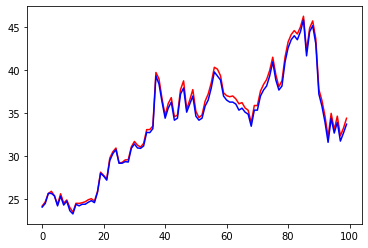

In [ ]:
plt.plot(ypred[1:101], color='red')
plt.plot(ytest[:100], color='blue')

In [ ]:
np.sqrt(mse(ytest,ypred))

2.263135143477193

In [ ]:
import pickle

In [ ]:
# to save the time of pre-processing when we test different designs of LSTM
pickle.dump([xtrain,xtest,ytrain,ytest],open("drive/MyDrive/Data Sets/JPSX.p", "wb"))

In [ ]:
model.save("drive/MyDrive/Data Sets")

INFO:tensorflow:Assets written to: drive/MyDrive/Data Sets/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Data Sets/assets
